# Evaluating a Text Classification Model




In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

In [0]:
!pip install flair==0.4.4 --quiet

In [0]:
# PATHS
from pathlib import Path

base_path = Path('/gdrive/My Drive/embeddings-comparison/resources')
#corpus_path = base_path/'corpora'
model_path = base_path/'models'/'classifiers'

In [0]:
import pickle
from pathlib import Path
from flair.models import SequenceTagger, TextClassifier
from flair.datasets import DataLoader
from flair.data import Sentence
from segtok.segmenter import split_single
from flair.visual.ner_html import render_ner_html
from flair.visual.training_curves import Plotter
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
from typing import List, Union
import spacy
from nltk.stem.snowball import GermanStemmer

#!python -m spacy download de_core_news_sm
plt.rc('axes', axisbelow=True)


class TextClassifierEvaluation():
    
    def __init__(
        self,
        path: Union[Path, str],
        model: str = 'best-model.pt'
    ):
        if type(path) == str:
            path = Path(path)
        assert path.exists()
        
        self.path = path
        self.model = TextClassifier.load(path/model)
        self.cv_results = {}
        for file in ['summary', 'details']:
            try:
                self.cv_results[file] = pickle.load((path/(file+'.pkl')).open(mode='rb'))
            except FileNotFoundError:
                print(f"{file+'.pkl'} not found. Setting cv_results['{file}'] to None")
        
        self.plotter = Plotter()
        
    def result_tables(
        self,
        save_as_html: bool = True
    ):
        html_0 = self.cv_results['summary'].to_frame('value').to_html()
        html_1 = self.cv_results['details'].to_html()
        display(HTML(html_0))
        print('\n')
        display(HTML(html_1))
        
        if save_as_html:
            (self.path/'summary.html').write_text(html_0)
            (self.path/'details.html').write_text(html_1)
    
    
    def plot_tag_stats(
        self,
        mode: str,
        savefig: bool = False,
        **kwargs
    ):
        """
        mode
        tp-fn: stacked barplot - true-positives and false-negatives
        tp-fp: bar plot - true-positives and false-positives
        """
        details = self.cv_results['details']
        
        if mode=='tp_fn': 
            details[['true-positive','false-negative']].plot.bar(stacked=True, **kwargs)
        elif mode=='tp_fp':
            details[['true-positive','false-positive']].plot.bar(stacked=False, **kwargs) 
        else:
            details[mode.split('_')].plot.bar(stacked=False, **kwargs)
                    
        plt.gca().yaxis.grid(True, linestyle='--')
        plt.tight_layout()
        if savefig:
            plt.savefig(self.path/(mode+'.png'), dpi=600)
            
            
    def confusion_matrix(
        self,
    ):
        # confusion matrix tags
        pass
        
        
    def predict(
        self,
        sentences: Union[str, Sentence, List[Sentence], List[str]],
        display_html: bool = True,
        html_file: str = None,
        display_str: bool = False,
        **kwargs
    ):
        if type(sentences) == Sentence:
            sentences = [sentences]
        elif type(sentences) == str:
            sentences = split_single(sentences)
        
        if type(sentences[0]) == str:
            sentences = [Sentence(s, use_tokenizer=True) for s in sentences]
        
        self.model.predict(sentences)

        if display_html or html_file:
            html = render_ner_html(sentences, **kwargs)
            if display_html:
                display(HTML(html))
            if html_file:
                (self.path/html_file).write_text(html)
        if display_str:
            for sentence in sentences:
                print(sentence.to_tagged_string())
                
                
    def plot_training_curves(
        self,
        plot_values: List[str] = ["loss", "F1"]
    ):
        self.plotter.plot_training_curves(self.path/'loss.tsv', plot_values)
    
    
    def plot_weights(self):
        self.plotter.plot_weights(self.path/'weights.txt')
    
    
    def plot_learning_rate(
        self,
        skip_first: int = 10, 
        skip_last: int = 5
    ):
        self.plotter.plot_learning_rate(self.path/'loss.tsv', skip_first, skip_last)

    @staticmethod    
    def _preprocess(text, mode=None):
        '''helper function to preprocess text. returns List of Sentences'''
        sentences = split_single(text)
        if mode:
            nlp = spacy.load('de_core_news_sm')
            if mode=='lemmatize':
                sentences = [Sentence((' ').join([token.lemma_ for token in nlp(s)])) for s in sentences]
            elif mode=='stem':
                stemmer = GermanStemmer()
                sentences = [Sentence((' ').join([stemmer.stem(token.text) for token in nlp(s)])) for s in sentences]
        else:
            sentences = [Sentence(s, use_tokenizer=True) for s in sentences]

        return sentences
    

In [0]:
!pip install pytorch_transformers --quiet

     |████████████████████████████████| 184kB 4.9MB/s 


In [0]:
classifier = TextClassifier.load(model_path/'cls-bert-CV'/'best-model.pt')

2019-11-09 22:05:48,137 loading file /gdrive/My Drive/embeddings-comparison/resources/models/classifiers/cls-bert-CV/best-model.pt


In [0]:
#classifier = TextClassifier.load('en-sentiment')
s = Sentence("Wie kann ich einen neuen Reisepass beantragen?")
classifier.predict(s)
print(s.labels)

[asked_ausweis_form (0.9999986886978149)]


In [0]:
c = TextClassifierEvaluation(model_path/'cls-bert-DE')

2019-11-09 22:06:49,085 loading file /gdrive/My Drive/embeddings-comparison/resources/models/classifiers/cls-bert-DE/best-model.pt


In [0]:
c.result_tables()

,value
precision,0.9966
recall,0.9966
f1-score,0.9966


,true-positive,false-positive,false-negative,true-negative,precision,recall,accuracy,f1-score
asked_ausweis_form,300,0,0,1171,1.000000,1.000000,1.000000,1.000000
asked_fahrzeug_form,399,1,1,1070,0.997500,0.997500,0.995012,0.997500
asked_how_are_you,30,1,0,1440,0.967742,1.000000,0.967742,0.983607
asked_melde_form,300,0,0,1171,1.000000,1.000000,1.000000,1.000000
asked_price,23,0,1,1447,1.000000,0.958333,0.958333,0.978723
asked_requirements,29,1,1,1440,0.966667,0.966667,0.935484,0.966667
asked_wohnsitz_form,200,2,0,1269,0.990099,1.000000,0.990099,0.995025
said_bye,30,0,0,1441,1.000000,1.000000,1.000000,1.000000
said_hello,45,0,0,1426,1.000000,1.000000,1.000000,1.000000
said_no,20,0,0,1451,1.000000,1.000000,1.000000,1.000000


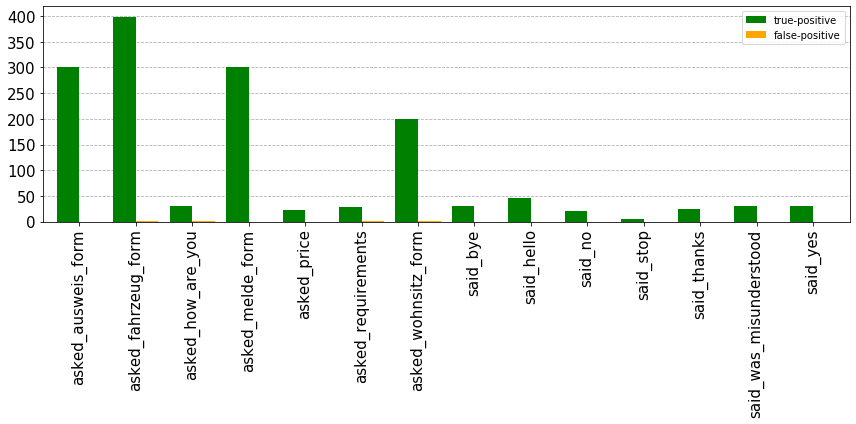

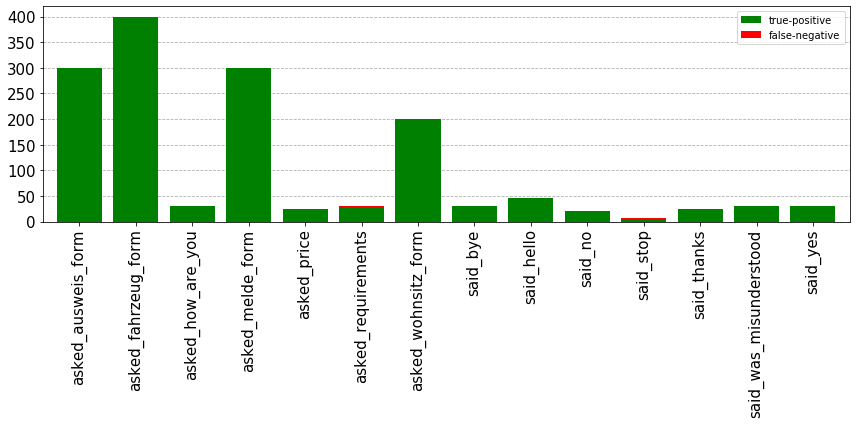

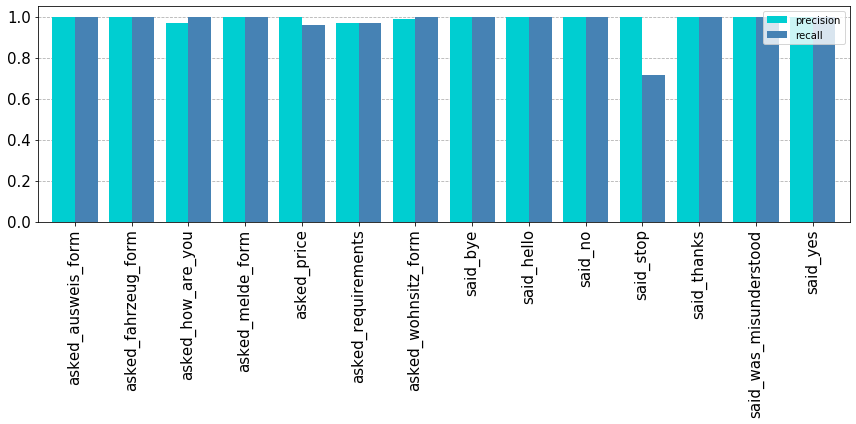

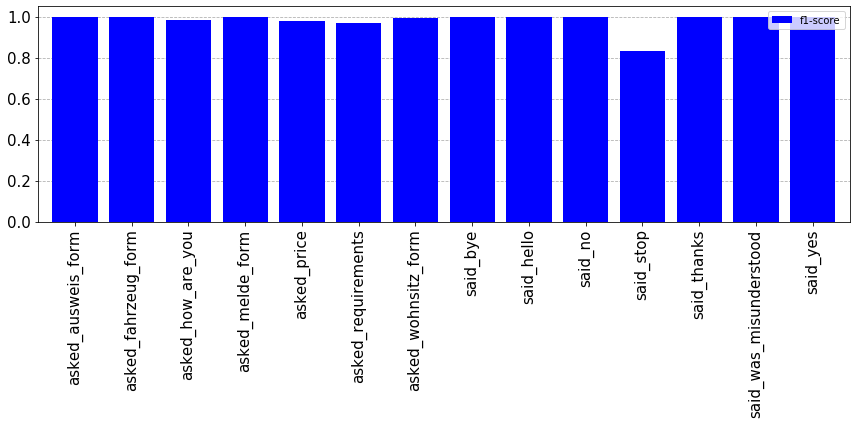

In [0]:
c.plot_tag_stats(mode='tp_fp', savefig=True, color=['green','orange'], width=0.8, figsize=(12, 6),fontsize=15)
c.plot_tag_stats(mode='tp_fn', savefig=True, color=['green','red'], width=0.8, figsize=(12, 6),fontsize=15)
c.plot_tag_stats(mode='precision_recall', savefig=True, color=['darkturquoise','steelblue'], width=0.8, figsize=(12, 6),fontsize=15)
c.plot_tag_stats(mode='f1-score', savefig=True, color='blue', width=0.8, figsize=(12, 6),fontsize=15)